In [1]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/4DCT/lib/pkgconfig'

In [39]:
import numpy as np
import scipy as sp
import fenics as fe
import fenics_adjoint as fa
from fenics import grad, dot, dx, ds
import torch
import torch_fenics
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import xarray as xr
import hvplot.xarray

In [40]:
[d for d in dir(fe) if d in dir(fa)]

['CompiledExpression',
 'Constant',
 'DirichletBC',
 'Expression',
 'Function',
 'KrylovSolver',
 'LUSolver',
 'LinearVariationalProblem',
 'LinearVariationalSolver',
 'NewtonSolver',
 'NonlinearVariationalProblem',
 'NonlinearVariationalSolver',
 'UserExpression',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'assemble',
 'assemble_system',
 'interpolate',
 'io',
 'project',
 'solve']

In [47]:
class PDESolver(torch_fenics.FEniCSModule):
    
    def __init__(self, n_nodes=21):
        super().__init__()
        
        # create function space
        n_elements = n_nodes - 1
        mesh = fe.UnitIntervalMesh(n_elements)
        self.V = fe.FunctionSpace(mesh, 'P', 1)
        
        # create trial and test functions
        u = fe.TrialFunction(self.V)
        self.v = fe.TestFunction(self.V)
        
        # construct bilinear form
        self.a = fe.inner(fe.grad(u), fe.grad(self.v)) * fe.dx
        
    def solve(self, f, g):
        
        # construct linear form
        L = f * self.v * fe.dx
        
        # construct boundary condition
        bc = fa.DirichletBC(self.V, g, 'on_boundary')
        
        # solve the Poisson equation
        u = fa.Function(self.V)
        fa.solve(self.a == L, u, bc)
        
        return u
    
    def input_templates(self):
        return fa.Function(self.V), fa.Constant(0)

pde_solver = PDESolver()

In [49]:
%%time
print('solving forward problem')
N = 10
f = torch.rand(N, 21, requires_grad=True, dtype=torch.float64)
g = torch.zeros(N, 1, requires_grad=True, dtype=torch.float64)
u = pde_solver(f, g)
u.shape

solving forward problem
Calling FFC just-in-time (JIT) compiler, this may take some time.
CPU times: user 64.8 ms, sys: 11.8 ms, total: 76.6 ms
Wall time: 517 ms


torch.Size([10, 21])

In [66]:
%%time
print('solving adjoint problem')
J = (u.abs()**2).sum()
J.backward()
dJdf = f.grad
dJdg = g.grad
dJdf.shape, dJdg.shape

solving adjoint problem
CPU times: user 476 ms, sys: 27.9 ms, total: 504 ms
Wall time: 510 ms


(torch.Size([10, 21]), torch.Size([10, 1]))

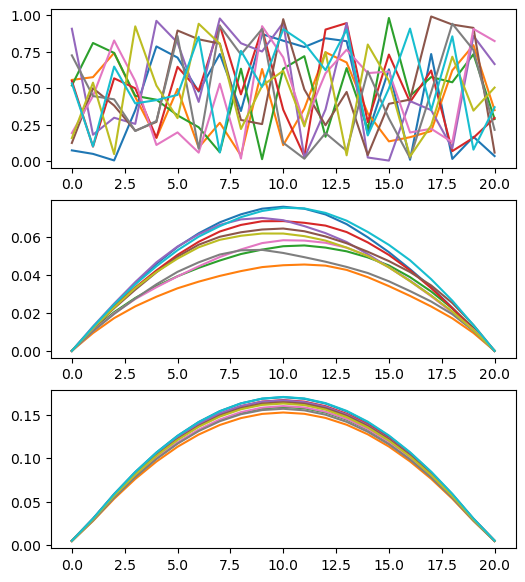

In [67]:
fig, ax = plt.subplots(3, 1, figsize=(6, 7))

for i in range(N):
    ax[0].plot(f[i].detach().cpu().numpy())
    ax[1].plot(u[i].detach().cpu().numpy())
    ax[2].plot(dJdf[i].detach().cpu().numpy())

In [65]:
def solve_forward(mu, n_nodes=81, omega=50, rho=1000, L=0.2, dt=1e-4, T=0.2):
    
    # mesh discretization
    n_elements = n_nodes - 1
    mesh = fe.UnitIntervalMesh(n_elements)
    V = fe.FunctionSpace(mesh, 'Lagrange', 1)
    
    # mapping from dofs to array indices
    coords = V.tabulate_dof_coordinates()
    inds = np.argsort(coords[:,0])
    
    # initial conditions
    ic_expression = fe.Constant(0)
    u0 = fe.interpolate(ic_expression, V)
    u1 = fe.interpolate(ic_expression, V)
    
    # Dirichlet boundary condition
    bc_expression = fe.Expression(f'sin(6.2831 * omega * t)', degree=0, t=0, omega=omega)

    def boundary(x, on_boundary):
        return on_boundary and fe.near(x[0], 0)
  
    u_bc = fe.DirichletBC(V, bc_expression, boundary)
    
    # source term and Neumann boundary condition
    f = fe.Expression('0', degree=0)
    g = fe.Expression('0', degree=1)
    
    # check CFL condition
    wave_speed = np.sqrt(mu0 / rho) / L
    mesh_spacing = 1 / n_elements
    cfl_number = wave_speed * dt / mesh_spacing
    assert cfl_number <= 1, f'CFL condition violated'
    
    # spatially varying physical parameters  
    c = fe.interpolate(ElasticityMap(x, mu), V)
    
    # construct variational form
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    a = (
        2 * u*v + 
        2*(c*dt)**2 * dot(grad(u),grad(v))
    ) * dx
    L = (
        (4*u1 - 2*u0 + 2*dt**2 * f)*v * dx +
        (g*v) * ds
    )

    n_steps = np.ceil(T / dt).astype(int)
    array = np.zeros((n_steps + 1, n_nodes))
    u = fe.Function(V)

    t = 0
    for i in tqdm.tqdm(range(n_steps)):
        t += dt
        bc_expression.t = t
        fe.solve(a == L, u, [u_bc])
        u0.assign(u1)
        u1.assign(u)
        values = u.vector().get_local()
        array[i+1] = values[inds].reshape((n_nodes,))
    
    return xr.DataArray(
        array,
        dims=['t', 'x'],
        coords={
            't': np.arange(0, n_steps+1) * dt,
            'x': np.linspace(0, 1, n_nodes)
        }
    )

In [ ]:
x = np.linspace(0, 1, 81)
mu = np.ones(81) * 4000
mu[(0.25 < x) & (x < 0.75)] = 16000

class ElasticityMap(fe.UserExpression):
    
    def __init__(self, x, mu):
        self.x = x
        self.mu = mu

    def eval(self, values, x):
        return sp.interpolate.interpn(self.x, self.mu, x)

mu_func = ElasticityMap(x[:,np.newaxis], mu[:,np.newaxis])

mu_array = xr.DataArray(
    mu,
    dims=['x'],
    coords={'x': x},
    name='mu'
)

In [ ]:
mu.hvplot(x='x', ylim=(0, 20000))

In [ ]:
mu_func.eval([0])

In [ ]:
u = solve_forward(mu)

In [ ]:
u.hvplot(
    groupby=['t'],
    x='x',
    ylim=(-2, 2),
    widget_type='scrubber',
    widget_location='bottom'
)

In [ ]:
u.shape

## Adjoint method derivation

A PDE constraint implicitly defines $\mathbf{u}(\mu)$:
$$
\begin{align*}
    \mathbf{r}(\mathbf{u};\mu) = 0
\end{align*}
$$

Loss function
$$
\begin{align*}
    L(\mathbf{u},\mu)
\end{align*}
$$

Loss gradient
$$
\begin{align*}
    dL &= \frac{\partial L}{\partial \mu} d\mu + \frac{\partial L}{\partial \mathbf{u}} d \mathbf{u} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} + \frac{\partial L}{\partial \mathbf{u}} \frac{d\mathbf{u}}{d\mu}
\end{align*}
$$

Assume that $\mathbf{r} = 0$
$$
\begin{align*}
    d\mathbf{r} &= 0 \\ 
    \frac{\partial \bf r}{\partial \bf u} d\mathbf{u} + \frac{\partial \bf r}{\partial \mu} d\mu &= 0 \\
    \frac{\partial \bf r}{\partial \bf u} \frac{d \bf u}{d \mu} + \frac{\partial \bf r}{\partial \mu} &= 0 \\
    \frac{\partial \bf r}{\partial \bf u} \frac{d \bf u}{d \mu} &= -\frac{\partial \bf r}{\partial \mu} \\
    \frac{d \bf u}{d \mu} &= -\frac{\partial \bf r}{\partial \bf u}^{-1} \frac{\partial \bf r}{\partial \mu}
\end{align*}
$$

This result is part of the implicit function theorem.

Then:
$$
\begin{align*}
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} + \frac{\partial L}{\partial \bf u} \frac{d \bf u}{d \mu} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \frac{\partial L}{\partial \bf u} \left( \frac{\partial \bf r}{\partial \bf u} ^{-1} \frac{\partial \bf r}{\partial \mu} \right) \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \left( \frac{\partial L}{\partial \bf u} \frac{\partial \bf r}{\partial \bf u} ^{-1} \right) \frac{\partial \bf r}{\partial \mu} \\
\end{align*}
$$

Direct method:

$$
\begin{align*}
    \Phi &= \frac{\partial \bf r}{\partial \bf u} ^{-1} \frac{\partial \bf r}{\partial \mu} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \frac{\partial L}{\partial \bf u} \Phi \\
    \operatorname{solve} \, \frac{\partial \bf r}{\partial \bf u} \Phi &= \frac{\partial \bf r}{\partial \mu}
\end{align*}
$$

Adjoint method:

$$
\begin{align*}
    \Psi^\top &= \frac{\partial L}{\partial \bf u} \frac{\partial \bf r}{\partial \bf u} ^{-1} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \Psi^\top \frac{\partial \bf r}{\partial \mu} \\
    \operatorname{solve} \, \frac{\partial \bf r}{\partial \bf u}^\top \Psi &= \frac{\partial L}{\partial \bf u}^\top
\end{align*}
$$

In either case, the output is $\frac{d L}{d \mu}$.

In [ ]:
class ImplicitPDELayer(object):

    def forward(self, mu):
        u = solve_pde(mu)
        return u

    def backward(self, dL_du, dL_dmu, dr_du, dr_dmu, method='adjoint'):
    
        if method == 'direct':
            phi = torch.linalg.solve(dr_du, dr_dmu)
            grad = dL_dmu - dL_du @ phi
    
        elif method == 'adjoint':
            psi = torch.linalg.solve(dr_du.T, dL_du.T)
            grad = dL_dmu - psi.T @ dr_dmu
            
        return grad
